# ***CSYE 7370 Deep Learning and Reinforcement Learning in Game Engineering*** 

##Student name :QIANG MA  
##NUID: 001057824


#Mini Project One: CartPole with Deep Q Learning

In [5]:
import random, numpy, math, gym

#-------------------- BRAIN ---------------------------
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.optimizers import *
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Initializing Global Variable & Functions

Initializing global variable that I will be using throughout the notebook

In [6]:
# Defining the problem
PROBLEM = 'CartPole-v0'

# Calculating the number of state (input) and the number
# of action (output)
TEMP_ENV = gym.make(PROBLEM)
STATECOUNT  = TEMP_ENV.observation_space.shape[0]
ACTIONCOUNT = TEMP_ENV.action_space.n

# Define the memory capacity, this will be a deque
# or a sumTree for FullDQN
MEMORY_CAPACITY = 50000

# Sampling batch size
BATCH_SIZE = 32

# Defining discount factors
GAMMA = 0.99

# Defining the learning rate for Keras
LEARNING_RATE = 0.00025

# Defining the probability of taking random action
# This is important for exploration, especially
# at the beginning of training. After each steps,
# multiply by lambda to reduce the epsilon
# to encourage exploitation
MAX_EPSILON = 1
MIN_EPSILON = 0.01

# Defining epsilon speed of decay
LAMBDA = 0.999

# Defining update frequency for DQN
UPDATE_TARGET_FREQ = 1000

Below  add function to:
- calculate the running mean
- calculate the max value of an array
- plot results in the form or Q value and rewards
- iterate over the environment

In [ ]:
def running_mean(arr, N):
    return np.convolve(arr, np.ones((N,))/N, mode='valid')

def max_q(arr):
    return np.max(np.array(arr)[:,0,:], axis = 1)

def plot_results(reward_arr, q_arr, N = 1, alpha = [1, 0.5], target_qval = 0):
    fig, ax = plt.subplots(figsize = (20,10))
    
    ax.plot(running_mean(reward_arr,N), color = '#65c9ff', label = 'running average reward', alpha = alpha[0])
    ax.plot(max_q(q_arr), color = '#ff9865', label = 'Q value', alpha = alpha[1])
    ax.axhline(target_qval, alpha = 0.2)
    ax.legend(loc='upper left', prop={'size': 16})
    ax.set_ylabel('Reward')
    ax.set_xlabel('# of episodes')
    ax.set_title('reward vs # of run over time', size = '18')
    ax.grid(alpha = 0.1)
    ax.set_axisbelow(True)
    ax.set_facecolor('#fcfaf8')
    fig.show()

In [ ]:
def run_environment(problem, agent, num_epochs, printEvery = None, randomAgent_initialization = True):
    env = Environment(problem)
    
    if randomAgent_initialization: 
        randomAgent = RandomAgent(agent.act_size)

        # initiating memory with random memory based on random actions
        while randomAgent.memory.isFull() == False:
            env.run(randomAgent)

        # adding random memory to the agent's memory
        agent.memory = randomAgent.memory
        randomAgent = None

    for e in tqdm(range(num_epochs)):
        reward = env.run(agent, train = True)
        if printEvery:
            if e % printEvery == 0: print("episode: {}/{}, score: {}".format(e, num_epochs, reward))
            
    return env

## Simple Deep Q Learning

### Defining Basic Structure

Below I will create the basic class that I will use to build my reinforcement learning. Adapted based on https://jaromiru.com/ and his great tutorial.

The structure consist of 4 main classes: **Memory, Agent, Environment, and Brain**

In [11]:
class Memory:
    '''
    Memory is the class that I am going to use to store memory. 
    I will call this class from the agent class whenever I need 
    to do a sampling on the memory 
    
    parameter:
    - capacity: capacity of memory
    '''
    
    def __init__(self, capacity):
        self.capacity = capacity
        
        # I will use deque for most of my memory class
        self.memory = deque(maxlen = capacity)
    
    def add(self, sample):
        # Add a sample to the memory list
        self.memory.append(sample)
    
    def sample(self, size):
        # calculate the possible number of sample, which is
        # a minimum of batch size and number of sample available
        batch_size = min(len(self.memory),size)
        
        # return samples based on the number of batch size
        return random.sample(self.memory, batch_size)

    def isFull(self):
        # check whether the memory is full or not
        return len(self.memory) >= self.capacity

In [14]:
class DQNAgent:
    '''
    Agent is the class where I built the reinforcement learning agent.
    Calls class memory and brain 
    
    parameter:
    - obs_size: observation / state size
    - act_size: action / output size
    '''
    
    def __init__(self, obs_size, act_size):
        self.obs_size = obs_size
        self.act_size = act_size
        
        # initiate steps. each observation is 1 step
        self.steps = 0
        
        # initiate epsilon to max epsilon
        self.epsilon = MAX_EPSILON
        self.learning_rate = LEARNING_RATE
        
        # define brain using brain class and memory as
        # memory class
        self.brain = Brain(obs_size, act_size)
        self.memory = Memory(MEMORY_CAPACITY)
    
    def act(self, state):
        # Determine action, based on prediction (exploitation)
        # or random action (exploration)
        if np.random.random() < self.epsilon:
            return np.random.choice(self.act_size)
        else:
            action = self.brain.predict(state)
            return np.argmax(action)
        
    def observe(self, sample):
        # Observe a sample, which will
        # - Add sample to mempry
        # - Increase steps
        # - Reduce epsilon
        self.memory.add(sample)
        self.steps += 1
        
        if self.epsilon > MIN_EPSILON:
            self.epsilon *= LAMBDA
        
    def replay(self, batch = 32):
        # Sample from batch, calling memory
        batch = self.memory.sample(batch)
        batchLen = len(batch)
        
        # Create empty arrays to indicate no future state
        # in case it's a terminal state
        no_state = np.zeros(self.obs_size)
        
        # Retreive the states from sample
        states = numpy.array([sample[0] for sample in batch])
        
        # Retreive the end states from sample. 
        # Replace this with no_state in case terminal
        states_ = numpy.array([(no_state if sample[4] is True else sample[3]) 
                               for sample in batch])
        
        # Calculate the Q tables based on  brain prediction
        Qtable = self.brain.predict(states)
        Qtable_ = self.brain.predict(states_)
        target_f = Qtable
        
        # For every batch, calculate the target Q-value based on real reward
        for i, sample in enumerate(batch):
            state, action, reward, state_, done = sample
            
            target = reward
            if not done:
                # Target Q-value (for that specific action) is defned as
                # Reward fron environment + Discount Factor * Future value
                # Future value is calculated based on max Q table for the state
                target = reward + GAMMA * np.max(Qtable_[i])
                
            target_f[i][action] = target
            
        self.brain.train(x = states, y = target_f)

In [15]:
class RandomAgent:
    '''
    RandomAgent is an agent which will always perform random action
    This will be used to fill up the memory with random observations
    
    parameter:
    - act_size: action / output size
    '''

    def __init__(self, actionCnt):
        self.actionCnt = actionCnt
        self.memory = Memory(MEMORY_CAPACITY)

    def act(self, s):
        # Always returns random action
        return random.randint(0, self.actionCnt-1)

    def observe(self, sample):  # in (s, a, r, s_) format
        # Add sample from the observed environment
        self.memory.add(sample)

    def replay(self):
        pass

In [16]:
class Brain:
    '''
    Brain is where I built deep learning model which I will use
    for training and prediction.
    
    parameter:
    - obs_size: observation / state size
    - act_size: action / output size
    - learning_rate: learning rate for the model
    '''
    def __init__(self, obs_size, act_size, learning_rate = 0.00025):
        self.obs_size = obs_size
        self.act_size = act_size
        self.learning_rate = learning_rate
        
        # Build deep learning model
        self.model = self._build_model()
    
    def _build_model(self):
        # A normal NN model is used
        model = Sequential()      
        model.add(Dense(activation= 'relu', units= 64, input_dim= self.obs_size))
        model.add(Dense(activation= 'linear', units= self.act_size))
        
        # Learning algorithm = adam
        rms = RMSprop(lr = self.learning_rate)
        model.compile(loss = 'mse', optimizer = rms)
        return model 
    
    def predict(self, state):
        # Return prediction based on the current model
        return self.model.predict(np.reshape(state, [-1, self.obs_size]))
    
    def train(self, x, y, epoch=1, verbose=0, batch_size= 32):
        # Train the model
        self.model.fit(x, y, batch_size = batch_size, epochs = epoch, verbose = verbose)
    

In [ ]:
class Environment:
    '''
    Environment class to hold the problem and regulate the running of 
    the environment
    
    parameter:
    - problem: The gym problem i.e. 'CartPole-v0'
    '''
    
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)
        
        # Create empty arrays to capture reward history and Q value progression
        self.reward_history = []
        self.value_function_history = []
        
        # Calculate values for normalization
        high = self.env.observation_space.high
        low = self.env.observation_space.low

        self.mean = (high + low) / 2
        self.spread = abs(high - low) / 2

    def normalize(self, s):
        # Normalization function of the state, if required
        return (s - self.mean) / self.spread
        
    def run(self, agent, train = False, render = False):
        state = self.env.reset()
        
        if train:
            comparison_state = np.array(state)
            self.value_function_history.append(agent.brain.predict(comparison_state))
        
        total_reward = 0
        max_steps = 5000
        
        idx = 0
        while True:
            if render: 
                self.env.render()
            
            action = agent.act(state)
            state_, reward, done, _ = self.env.step(action)
            
            if done: 
                state_ = None          
            
            agent.observe( (state, action, reward, state_, done) )
            agent.replay()
            
            state = state_
            total_reward += reward
            
            if done: 
                break
                if render: self.env.render(close = True)
                    
            idx += 1
        
        if train: 
            self.reward_history.append(total_reward)
            
        return total_reward

### Start Training

In [ ]:
agent = DQNAgent(STATECOUNT, ACTIONCOUNT)
env_dqn = run_environment(PROBLEM, agent, num_epochs = 4000)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 4000/4000 [13:28<00:00,  4.94it/s]


In [ ]:
model_json = agent.brain.model.to_json()
with open("CartPole_DQN.json", "w") as json_file:
    json_file.write(model_json)
agent.brain.model.save("CartPole_DQN.h5")

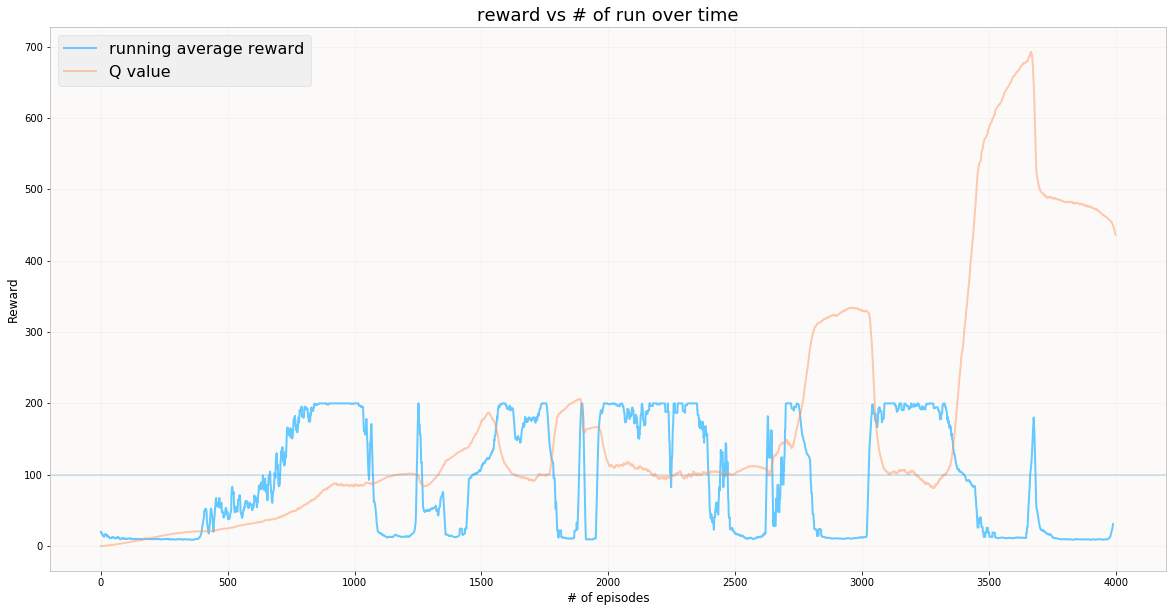

In [ ]:
plot_results(env_dqn.reward_history, env_dqn.value_function_history, N = 10, alpha = [1, 0.5], target_qval = 100)

The above is the plot of the Q-value (in orange) and the reward plot (in blue). As you can see,  Q network based on a simple neural network is able to learn what to do just fine, indicated that I am able to achieve running average of 200 points (max). 

However, I also notice that there is quite a lot of variability of the run rate, at which at some point nearly drop to ~10 range, which is not that much different from a random coin-toss *(not verified)*. I notice that, especially towards the end of training, this correlates with the Q value being too high than they're supposed to (see episodes 2500+).

With this model, `target = reward + GAMMA * np.max(Qtable_[i])`, my target is always moving as  Q-table is always changing in every iteration. This makes the Q-learning a bit unstable which results in performance decline.

The aim of Double Deep Q Network is to fix that and bring stability to the model

## Double DQN With Experience Replay

### Defining additional functions

For prioritized experience replay, I would need a new class, **SumTree**. For my memory class, I will be using this instead of a normal deque python function. This is because I need to 'sort' the memories and would need to pick more important memories more often. 

I will sort the memories based on it's error value during learning of sampling denoted by $error = \left| Q(s,a) - T(S) \right|$, where $T(S)$ is the target value for a specific $(s,a)$

I  will then convert this error value to a priority value $p = \left( error + \epsilon \right)^\alpha$. The higher the priority, the higher the chance that it will get picked.

In [ ]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 ) # Total Nodes in a binary tree = 2 x Capacity - 1
        self.data = numpy.zeros( capacity, dtype=object )
        self.leafId = range(capacity - 1, 2*capacity - 1)
        self.isFull = False
    
    def _propagate(self, idx, change):
        parent_id = (idx - 1) // 2
        self.tree[parent_id] += change
        
        if parent_id != 0: self._propagate(parent_id, change)
        
    def _retreive(self, idx, s):
        if self._isLeaf(idx): return idx
        
        childId = self._getChildId(idx)
        leftTreeValue = self.tree[childId[0]]
        
        if  leftTreeValue >= s:
            return self._retreive(childId[0], s)
        else:
            return self._retreive(childId[1], s - leftTreeValue)

    def _getChildId(self, idx):
        return [idx * 2 + 1, idx * 2 + 2]
    
    def _isLeaf(self, idx):
        return idx in self.leafId
        
    def push(self, sample, priority):
        tree_id = self.capacity - 1 + self.write #leaf nodes count starts from capacity - 1
        change = priority - self.tree[tree_id]
        
        self.data[self.write] = sample
        self.tree[tree_id] = priority
        self._propagate(tree_id, change)
                
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
            self.isFull = True
    
    def get(self, s):
        idx = self._retreive(0, s)
        dataIdx = idx - self.capacity + 1
        
        return idx, self.tree[idx], self.data[dataIdx]
    
    def total(self):
        return self.tree[0]

Additionally, I will also use a different loss function, the huber loss, in order to smoothen my loss function and avoid any major change due to large deviations during the backpropagation process introduced by MSE loss function

In [ ]:
HUBER_LOSS_DELTA = 2.0

def huber_loss(y_true, y_pred):
    err = y_true - y_pred

    cond = K.abs(err) < HUBER_LOSS_DELTA
    L2 = 0.5 * K.square(err)
    L1 = HUBER_LOSS_DELTA * (K.abs(err) - 0.5 * HUBER_LOSS_DELTA)

    loss = tf.where(cond, L2, L1) 

    return K.mean(loss)

### Defining Basic Structure

I will still use the same structure as DQN.
The structure consist of 4 main classes: **Memory, Agent, Environment, and Brain**

In [17]:
class DDQNBrain:
    '''
    Brain is where I built deep learning model which I will use
    for training and prediction.
    
    parameter:
    - obs_size: observation / state size
    - act_size: action / output size
    - learning_rate: learning rate for the model
    
    '''
    def __init__(self, obs_size, act_size, learning_rate = 0.0003):
        self.obs_size = obs_size
        self.act_size = act_size
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.model_ = self._build_model()
    
    def _build_model(self):
        model = Sequential()      
        model.add(Dense(activation= 'relu', units = 64, input_dim = self.obs_size))
        model.add(Dense(activation='linear', units=self.act_size))
        
        adam = Adam(lr = self.learning_rate)
        model.compile(loss = huber_loss, optimizer = adam)
        return model 
    
    def predict(self, state, target = False):
        if not target:
            return self.model.predict(np.reshape(state, [-1, self.obs_size]))
        else:
            return self.model_.predict(np.reshape(state, [-1, self.obs_size]))

    def updateTargetModel(self):
        # update target model by taking the latest value from the
        # main network after every N iterations
        
        self.model_.set_weights(self.model.get_weights())
    
    def train(self, x, y, epoch=1, verbose=0):
        self.model.fit(x, y, batch_size = 32, epochs = epoch, verbose = verbose)

In [10]:
class EfficientMemory:
    '''
    Memory is the class that I am going to use to store memory. 
    call this class from the agent class whenever I need 
    to do a sampling on the memory. For EfficientMemory, I will be 
    utilizing SumTree insted of a normal deque to improve the sp-
    -eed of which will read from  memory class
    
    parameter:
    - capacity: capacity of memory
    '''
        
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = SumTree(capacity)
        self.epsilon = 0.01
        self.alpha = 0.6
    
    def add(self, sample, error):
        # add sample to memory
        self.tree.push(sample, self.calculatePriority(error))
    
    def sample(self, size, stratified = True):
        # take min (size, memory_size) sample from memory
        if not self.tree.isFull: 
            batch_size = self.tree.write
        else: 
            batch_size = size
        
        # Sampling can be done in 2 ways. I can just generate 
        # 0 < s < sum(prio) and find sample. Draw back of this 
        # is that I might have a repeated sample in the batch
        # However, I can also something which is more similar
        # to a stratified sampling in order to ensure more "segments" 
        # are sampled from.
        sample = []
        
        segments = self.tree.total() / batch_size
        
        if stratified:
            for idx in range(batch_size):
                low = segments * idx
                high = segments * (idx + 1)
                s = np.random.uniform(low, high)
                idx, prio, data = self.tree.get(s)
                sample.append(data)
        else:
            for idx in range(batch_size):
                s = np.random.uniform(0, self.tree.total())
                idx, prio, data = self.tree.get(s)
                sample.append(data)
        
        return sample

    def isFull(self):
        # return True if tree is full and false otherwise
        return self.tree.isFull
    
    def calculatePriority(self, error):
        # calculate priority, given predefined alpha
        return (error + self.epsilon) ** self.alpha

In [13]:
class FullDDQNAgent:
    '''
    Agent is the class where I built the reinforcement learning agent.
    Calls class EfficientMemory and DQNBrain .
    
    parameter:
    - obs_size: observation / state size
    - act_size: action / output size
    '''
    
    steps = 0
    epsilon = MAX_EPSILON
    
    def __init__(self, obs_size, act_size):
        self.memory = EfficientMemory(MEMORY_CAPACITY)
        self.obs_size = obs_size
        self.act_size = act_size
        self.epsilon = MAX_EPSILON
        self.learning_rate = LEARNING_RATE
        self.brain = DDQNBrain(obs_size, act_size)
        
    
    def act(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.act_size)
        else:
            action = self.brain.predict(state)
            return np.argmax(action)

    def observe(self, sample):
        # Get error value before saving it to memory
        _, _, error = self._getTargets([sample])
        
        self.memory.add(sample, error[0])
        self.steps += 1
        
        if self.epsilon > MIN_EPSILON:
            self.epsilon *= LAMBDA
        
        # Update the target network every N iterations
        # This is previously not required for the simple
        # DQN as only one network is used
        if self.steps%UPDATE_TARGET_FREQ == 0:
            self.brain.updateTargetModel()
    
    def _getTargets(self, batch):
        # Create empty arrays to indicate no future state
        # in case it's a terminal state        
        no_state = np.zeros(self.obs_size)
        
        # Retreive the states from sample
        states = numpy.array([sample[0] for sample in batch])
        
        # Retreive the end states from sample. 
        # Replace this with no_state in case terminal
        states_ = numpy.array([(no_state if sample[4] is True 
                                else sample[3]) for sample in batch])
        
        # Calculate the Q tables based on brain prediction
        Qtable = self.brain.predict(states, target = False)
        Qtable_ = self.brain.predict(states_, target = False)
        
        # Calculate the target Q table
        TargetQtable = self.brain.predict(states_, target = True)
        target_f = Qtable
        
        error = np.zeros(len(batch))
        
        # Instead of using the random version DDQN, I will utilize slow 
        # moving copy to evaluate the best action according to the main Q network
        # which has also been proved to decorrelate the Q-value estimates well
        for i, sample in enumerate(batch):
            state, action, reward, state_, done = sample
            target = reward
            if not done:
                target = reward + GAMMA * TargetQtable[i][np.argmax(Qtable_[i])]
            
            error[i] = np.abs(Qtable[i][action] - target)
            target_f[i][action] = target
        
        return states, target_f, error
    
    def replay(self, batch = 32):
        # sample from batch and train brain
        batch = self.memory.sample(batch)
        batchLen = len(batch)
        
        states, target_f, _ = self._getTargets(batch)
            
        self.brain.train(x = states, y = target_f)

In [ ]:
class RandomAgent:
    '''
    RandomAgent is an agent which will always perform random action
    This will be used to fill up  memory with random observations
    
    parameter:
    - act_size: action / output size
    '''
    
    def __init__(self, actionCnt):
        self.actionCnt = actionCnt
        self.memory = EfficientMemory(MEMORY_CAPACITY)

    def act(self, s):
        return random.randint(0, self.actionCnt-1)

    def observe(self, sample):  # in (s, a, r, s_) format
        # for random agent, add reward as sample
        self.memory.add(sample, np.abs(sample[2]))

    def replay(self):
        pass

### Start Training

In [ ]:
agent = FullDDQNAgent(STATECOUNT, ACTIONCOUNT)
env_fullddqn = run_environment(PROBLEM, agent, num_epochs = 4000)

model_json = agent.brain.model.to_json()
with open("CartPole_FullDQN.json", "w") as json_file:
    json_file.write(model_json)
agent.brain.model.save("CartPole_FullDDQN.h5")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 4000/4000 [43:16<00:00,  1.54it/s]


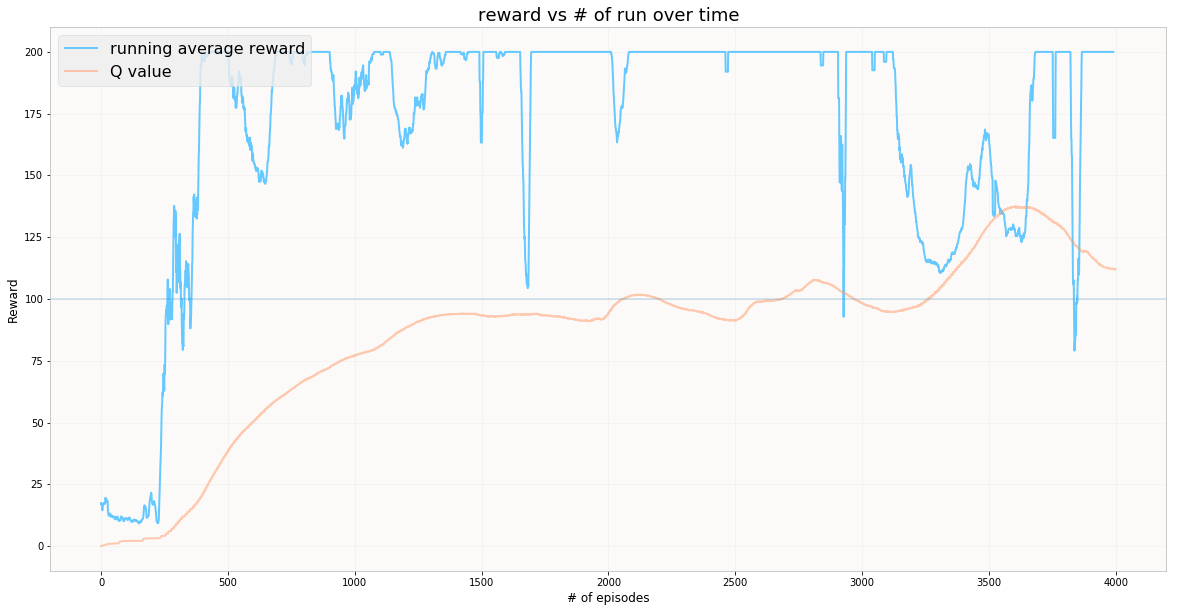

In [ ]:
plot_results(env_fullddqn.reward_history, env_fullddqn.value_function_history, N = 10, alpha = [1, 0.5], target_qval = 100)

# Side by Side Performance Comparison

Now I have performance data for both the Deep Q Network Agent and Double Deep Q Network (with Prioritized Learning) Agent. I'll just do a quick simulation below to compare the performance with random Agent to compare it side by side.

In [ ]:
def run_random(problem, N):
    env = gym.make(problem)
    reward_history = []
    for i in range(N):
        state = env.reset()
        total_reward = 0
        while True:
            action = env.env.action_space.sample()
            state_, reward, done, _ = env.step(action)

            total_reward += reward

            if done: 
                reward_history.append(total_reward)
                break
                
    return reward_history

In [ ]:
random_history = run_random(PROBLEM, 4000)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


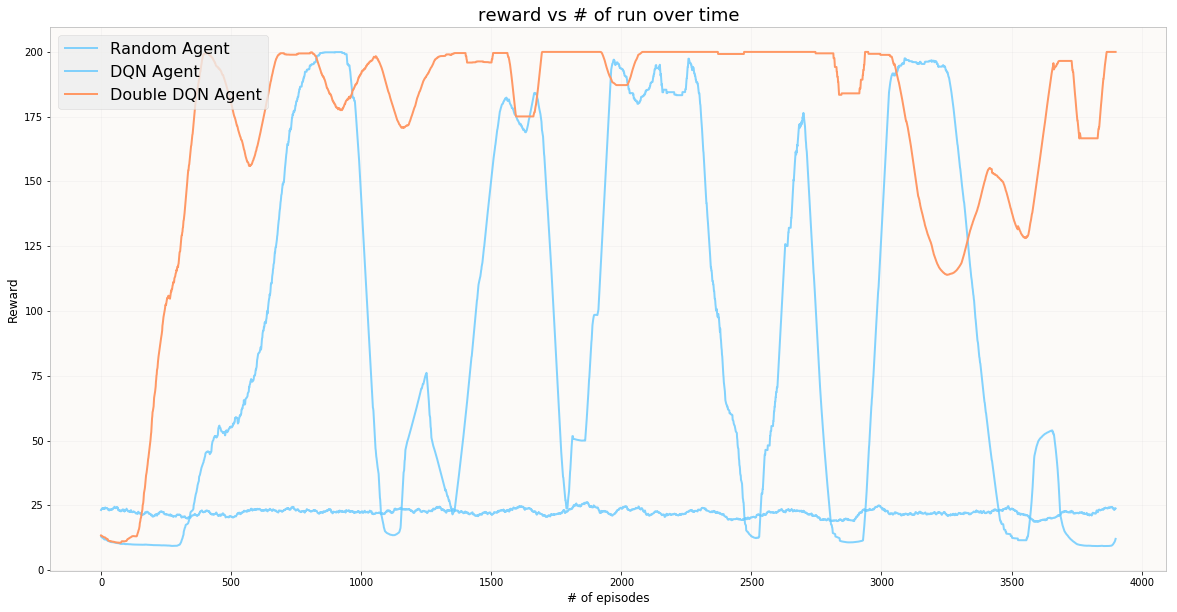

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
    
ax.plot(running_mean(random_history, 100), color = '#65c9ff', label = 'Random Agent', alpha = 0.8)
ax.plot(running_mean(env_dqn.reward_history, 100), color = '#65c9ff', label = 'DQN Agent', alpha = 0.8)
ax.plot(running_mean(env_fullddqn.reward_history, 100), color = '#ff9865', label = 'Double DQN Agent', alpha = 1)

ax.legend(loc='upper left', prop={'size': 16})
ax.set_ylabel('Reward')
ax.set_xlabel('# of episodes')
ax.set_title('reward vs # of run over time', size = '18')
ax.grid(alpha = 0.1)
ax.set_axisbelow(True)
ax.set_facecolor('#fcfaf8')
fig.show()

References:
1. https://jaromiru.com
2. https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/
3. https://arxiv.org/abs/1509.06461

#*License*

Copyright <2020> Qiang Ma<COPYRIGHT QIANG MA>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.